## 基于GP自动构造特征优化决策树交叉验证损失

**——为什么使用GP而不是神经网络？**

在机器学习领域，特征工程是非常重要的一环。特征工程的目标是构造出对于机器学习算法来说更加有用的特征，以提高模型的性能。特征工程的方法有很多，包括但不限于：
* 核方法：将原始特征映射到更高维的特征空间，以便更容易地进行分类或回归。要求基础模型必须存在内积运算。
* 神经网络：使用神经网络来构造新特征。要求基础模型必须可导。

本文则重点关注遗传编程，即使用遗传编程（GP）来构造新特征。遗传编程是一种进化算法，它通过模拟自然选择的过程来优化问题的解。
在遗传编程中，每个解都是一个程序，程序的输入是原始特征，输出是新特征。遗传编程通过不断地进化，来寻找最优的特征构造程序。

### 遗传编程优势
**无梯度优化：相比核方法和神经网络，遗传编程的优势在于它能够优化交叉验证误差，以及任意基础学习模型，而不是直接优化训练误差，以及必须要求可导模型。这意味着遗传编程能够更好地避免过拟合，同时具有更好灵活性。**

**符号表示：相比核方法和神经网络，遗传编程基于符号表示，这意味着构造出的特征具有非常好的可解释性。**

**种群优化：分布式搜索，可以线性扩展到集群上。（注：神经网络的局部最优曾经被认为是一个问题，目前越来越多的研究表明神经网络的大部分Critical Point是鞍点。）**

### 为什么不使用神经网络？
#### 决策树->不可微分->无法使用神经网络构造特征
![决策树](img/DT.png)

决策树的不可微分性：

想象决策树就像一个"是/否"问题的连续提问。比如判断一个水果是不是苹果：

- "重量大于150g吗？" -> 是/否
- "是红色的吗？" -> 是/否
- "有梗吗？" -> 是/否

这种"是/否"的选择是跳跃式的，没有平滑过渡。这就像开关，要么开要么关，没有"半开"的状态。在数学上，这种跳跃式的变化是不可微分的，因为在跳跃点处无法计算斜率（导数）。神经网络需要通过计算梯度（导数）来学习和优化，但决策树的这种跳跃式分支使得无法计算梯度。

#### 交叉验证误差->不可微分->无法使用梯度下降优化
![交叉验证误差](img/CV.png)

交叉验证误差的不可微分性：

图中展示了5折交叉验证的过程。每一次验证都是在不同的数据集上进行的，这就像在不同的"赛道"上测试赛车性能。问题在于：

- 每次验证的结果都是独立的
- 验证结果是离散的评分（比如准确率90%）
- 不同折之间的变化不是连续的

这种离散的、独立的评估方式使得我们无法得到一个平滑的、可导的误差函数，因此无法直接使用基于梯度的优化方法。

#### 传统神经网络->难以解释/内存占用高
![大模型](img/NN.png)

传统神经网络的局限：

图中展示了一个多层神经网络，就像一个复杂的信号处理工厂：

- 每个神经元都与其他层的多个神经元相连
- 连接错综复杂，像蜘蛛网一样
- 需要存储大量的连接权重

这带来两个问题：

1. 解释性差：很难解释为什么网络做出某个决定，就像我们很难解释为什么一个黑盒给出特定输出
2. 内存占用高：需要存储所有连接的权重，就像需要记住蜘蛛网上每根丝的粗细

#### 梯度优化->难以大规模并行
![局部最优](img/Parallel.png)

梯度优化的并行化困难：

想象一群登山者在寻找山顶：

- 传统梯度优化就像每个登山者都需要等待其他人的信息才能决定下一步往哪走
- 这种依赖关系使得难以让登山者们完全独立行动
- 而图中展示的并行方法，每个"Evaluate model"都可以独立运行，像多个完全独立的登山队同时在不同的山上搜索

通过使用遗传编程（GP），我们可以避免这些限制：

- 不需要计算梯度
- 评估可以完全并行
- 结果具有更好的可解释性
- 内存占用相对较低

### 评估函数
如上文所述，遗传编程的目标是优化交叉验证误差，而不像传统的特征工程方法那样优化训练误差。

值得一提的是，这里的交叉验证误差是在训练集上的交叉验证误差，而不是在测试集上的误差。

通过一个具体的例子来解释这个概念。

假设我们正在开发一个预测房价的模型。我们有以下数据：
- 训练集：1000个房屋数据
- 测试集：200个房屋数据

传统的特征工程方法：
在传统方法中，我们会直接尝试优化训练误差。比如，我们可能会创建一个新特征："房屋面积 × 房间数量"，然后看这个特征是否能减少训练集上的预测误差。这种方法可能会导致过拟合，因为我们过度针对训练数据优化了特征。

遗传编程的方法：
遗传编程采用一个更稳健的方案，使用交叉验证误差作为评估标准。具体来说：

1. 把训练集（1000个数据）分成5份，每份200个数据
2. 对于每个候选特征（比如"房屋面积 × 房间数量"），我们：
   - 使用其中4份数据（800个）来训练模型
   - 在剩下1份（200个）上验证
   - 重复5次，每次使用不同的验证集
   - 取平均误差作为这个特征的评分

关键点在于：
- 我们从未使用测试集（那200个数据）来评估特征的好坏
- 即使在训练集内，我们也始终保持着"训练-验证"的分离
- 这种方法能更好地评估特征的泛化能力

这就像：
- 传统方法：在一个考试题库上反复练习，直到能完美回答所有题目
- 遗传编程方法：把题库分成几份，每次用部分题目练习，用其他题目测试，这样更能确保真正的学习效果

这种方法的优势是：
1. 更可靠：特征的评分更能反映其实际效果
2. 更稳定：不容易过度适应训练数据的特定模式
3. 更有说服力：每个特征都经过了多轮的交叉验证

这就是为什么遗传编程选择使用交叉验证误差而不是简单的训练误差来评估特征的品质。这种方法虽然计算量更大，但能产生更可靠和泛化能力更强的特征。

In [2]:
# pip install gplearn
from gplearn.functions import _protected_division
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits, load_wine
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 加载糖尿病数据集作为示例
X, y = load_diabetes(return_X_y=True)
# 将数据集分为训练集和测试集，测试集占20%
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
# 创建标准化器实例
scaler = StandardScaler()
# 对训练数据进行拟合和转换
train_X = scaler.fit_transform(train_X)
# 对测试数据只进行转换，不能拟合
test_X = scaler.transform(test_X)
"""
假设有：
训练数据：[1, 2, 3, 4, 5]
测试数据：[6, 7, 8]

fit_transform() 在训练数据上：
1. 计算平均值：3
2. 计算标准差：1.58
3. 转换数据：[(1-3)/1.58, (2-3)/1.58, ...]
结果：[-1.26, -0.63, 0, 0.63, 1.26]

transform() 在测试数据上：
1. 使用训练数据的平均值(3)和标准差(1.58)
2. 转换数据：[(6-3)/1.58, (7-3)/1.58, (8-3)/1.58]
结果：[1.89, 2.52, 3.15]
"""

# 评估函数定义
# 求解问题的目标是最大化回归交叉验证分数
def evalFeatureEngineering(individuals):
    """
    使用遗传编程来生成新的特征
    每个特征都通过交叉验证来评估其质量
    使用决策树作为基础模型来测试特征的有效性
    整个过程包含了数据预处理（标准化）和验证（交叉验证）
    """
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        # 对每条记录应用特征构造函数
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组，使其符合scikit-learn的输入格式
    new_features = np.transpose(np.array(new_features))

    # 使用决策树进行回归
    model = DecisionTreeRegressor(min_samples_leaf=10)

    # 使用交叉验证计算误差
    scores = cross_val_score(model, new_features, train_y, cv=5)

    # 返回平均分数
    return scores.mean(),

### 多树GP个体表示
对于特征构造，每个GP个体可以是一个Tree列表，即一个个体包含多个特征，每个Tree代表一个新特征。

In [3]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.tree import DecisionTreeRegressor

# 设置随机种子，确保结果可重现
np.random.seed(0)
random.seed(0)

def _protected_division(x1, x2):
    """
    安全的除法操作，处理除数为零的情况
    当除数接近零时返回1，否则正常执行除法
    """
    with np.errstate(divide='ignore', invalid='ignore'): # 忽略除零警告
        return np.where(np.abs(x2) > 0.001,  # 如果除数绝对值大于0.001
                        np.divide(x1, x2), # 执行正常除法
                        1.  # 否则返回1
                        )


# 创建GP框架的基本组件
pset = gp.PrimitiveSet("MAIN", X.shape[1]) # X.shape[1]是输入特征的数量
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(_protected_division, 2)
pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)

# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/home/glk/project/anaconda3/lib/python3.11/site-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


seed(0)的作用：

```python
# 不设置随机种子的情况
import random

# 第一次运行
print(random.random())  # 可能输出：0.723
print(random.random())  # 可能输出：0.154

# 第二次运行
print(random.random())  # 可能输出：0.891
print(random.random())  # 可能输出：0.437

# 设置随机种子的情况
random.seed(0)

# 第一次运行
print(random.random())  # 输出：0.844
print(random.random())  # 输出：0.758

# 重新设置相同的种子
random.seed(0)

# 第二次运行
print(random.random())  # 仍然输出：0.844
print(random.random())  # 仍然输出：0.758
```

### 交叉/变异算子
对于多树GP，很明显我们还需要自己定义交叉和变异算子。这里我们对DEAP中的交叉和变异算子进行简单包装，将其改造成能够处理多棵树的列表结构的算子。

In [4]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=6)

def initIndividual(container, func, size):
    """创建一个包含多棵特征树的个体"""
    return container(gp.PrimitiveTree(func()) for _ in range(size))

def cxOnePointListOfTrees(ind1, ind2):
    """对两个个体的每对树进行交叉操作"""
    for tree1, tree2 in zip(ind1, ind2):
        gp.cxOnePoint(tree1, tree2)
    return ind1, ind2

def mutUniformListOfTrees(individual, expr, pset):
    """对个体中的每棵树进行随机变异"""
    for tree in individual:
        gp.mutUniform(tree, expr=expr, pset=pset)
    return individual,


toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)  # 假设我们创建3个特征
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, pset=pset)
toolbox.register("compile", gp.compile, pset=pset)

最后，演化流程与传统的GP算法没有区别。直接运行即可。

In [5]:
# 运行遗传编程算法
population = toolbox.population(n=100)
hof = tools.HallOfFame(1)

# 统计和日志
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=stats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)


gen	nevals	avg       	std     	min      	max     
0  	100   	-0.0352535	0.184681	-0.465253	0.408738
1  	93    	0.0644668 	0.184211	-0.401944	0.42935 
2  	95    	0.164617  	0.176327	-0.345223	0.453795
3  	87    	0.257854  	0.123272	-0.185119	0.453795
4  	94    	0.275092  	0.13214 	-0.228863	0.425609
5  	84    	0.304867  	0.110798	-0.0778575	0.427339
6  	88    	0.292916  	0.144577	-0.315127 	0.437872
7  	89    	0.301983  	0.151803	-0.380469 	0.439317
8  	91    	0.321926  	0.131414	-0.234202 	0.454113
9  	98    	0.326328  	0.136062	-0.246197 	0.45335 
10 	86    	0.303931  	0.143638	-0.185107 	0.45335 
Best individual is: ['subtract(ARG5, subtract(ARG0, ARG7))', 'add(ARG8, ARG2)', 'add(ARG1, ARG1)']
With fitness: (0.45411339055004607,)


分析运行结果：

解释输出的各个列：
- gen：代数（generation）
- nevals：每代中评估的新个体数量
- avg：该代所有个体的平均适应度
- std：适应度的标准差
- min：最低适应度
- max：最高适应度

观察进化过程的几个关键趋势：

1. 平均适应度（avg）的变化：
- 起始值为 -0.0353（第0代）
- 持续上升到 0.3263（第9代）
- 最后稍微下降到 0.3039（第10代）
这表明种群整体素质在不断提升，特征工程效果在逐渐改善。

2. 最大适应度（max）的演变：
- 从 0.4087（第0代）
- 最终达到 0.4534（第10代）
虽然提升看起来不是很大，但这说明算法确实找到了更好的特征组合。

3. 最小适应度（min）的改善：
- 从 -0.4653（第0代）
- 提升到 -0.1851（第10代）
这表明算法成功淘汰了许多表现差的特征组合。

4. 标准差（std）的变化：
- 从 0.1847（第0代）
- 降低到 0.1436（第10代）
标准差的减小表明种群逐渐收敛，个体间的差异在减小。

最终得到的最佳个体：
```python
['subtract(ARG5, subtract(ARG0, ARG7))', 
 'add(ARG8, ARG2)', 
 'add(ARG1, ARG1)']
```

这三个特征的含义是：
1. 特征1：ARG5 - (ARG0 - ARG7)，相当于 ARG5 + ARG7 - ARG0
2. 特征2：ARG8 + ARG2，简单的两个原始特征相加
3. 特征3：ARG1 + ARG1，相当于 2*ARG1

适应度值为0.4541，这是一个相对不错的结果，考虑到适应度范围大约在-0.5到0.5之间。

这个结果告诉我们：
1. 算法成功找到了有意义的特征组合
2. 进化过程是稳定的，没有出现剧烈波动
3. 最终的特征组合相对简单，具有良好的可解释性
4. 还有进一步优化的空间，因为进化曲线在第10代时仍未完全平稳

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_predictions(train_y, predicted_train_y, test_y, predicted_y, name):
    # 计算训练集和测试集的R²分数
    training_r2 = r2_score(train_y, predicted_train_y)
    r2 = r2_score(test_y, predicted_y)
    sns.set_style("whitegrid")
    plt.scatter(test_y, predicted_y)
    plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} Training R² Score: {training_r2:.3f} \n Test R² Score: {r2:.3f}')
    plt.show()

### 评估最佳个体在测试集上的性能
对于最佳个体，我们可以使用它构造的新特征来训练模型，并使用该特征转换测试集，然后评估模型在测试集上的性能。

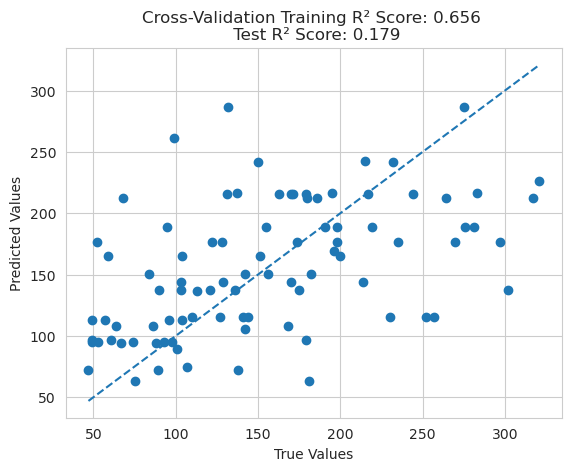

0.17898444441640715

In [8]:
def evaluationOnTest(trees, name):
    # 第一部分：在训练集上进行预测
    new_features = []
    for ind_num, ind in enumerate(trees):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))
    model = DecisionTreeRegressor(min_samples_leaf=10)
    model.fit(new_features, train_y)
    train_y_pred = model.predict(new_features)

    # 第二部分：在测试集上进行预测
    new_features = []
    for ind_num, ind in enumerate(trees):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in test_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 返回训练误差
    score = r2_score(test_y, model.predict(new_features))
    # 绘制图表
    plot_predictions(train_y, train_y_pred, test_y, model.predict(new_features), name)
    return score


evaluationOnTest(best_ind, "Cross-Validation")

### 直接优化训练误差的GP
当然，我们也可以使用遗传编程来优化训练误差（而不是之前我们看到的交叉验证误差）。

与之前使用交叉验证误差的方法相比，这种直接优化训练误差的方法：

1. 计算速度更快（不需要多次交叉验证）
2. 但可能更容易导致过拟合（因为没有验证集的反馈）
3. 需要更谨慎地控制模型复杂度（这就是为什么决策树设置了min_samples_leaf=10）

gen	nevals	avg     	std     	min      	max    
0  	0     	0.303931	0.143638	-0.185107	0.45335
1  	88    	0.55985 	0.0987481	0.256506 	0.665762
2  	90    	0.590953	0.0693942	0.267409 	0.682302
3  	86    	0.605792	0.070243 	0.310435 	0.676585
4  	92    	0.599634	0.0660101	0.379885 	0.685347
5  	89    	0.596156	0.0815029	0.301172 	0.684787
6  	94    	0.592179	0.0792609	0.291761 	0.676509
7  	86    	0.599535	0.082606 	0.276139 	0.67517 
8  	89    	0.614152	0.0673441	0.376966 	0.699104
9  	91    	0.593205	0.0781903	0.229489 	0.680216
10 	85    	0.608815	0.0651021	0.336586 	0.684946
Best individual is: ['subtract(ARG0, add(ARG1, ARG2))', 'add(ARG8, ARG2)', 'add(subtract(add(ARG6, ARG6), multiply(add(ARG9, ARG0), ARG3)), multiply(ARG6, add(ARG6, ARG0)))']
With fitness: (0.6991039640945576,)


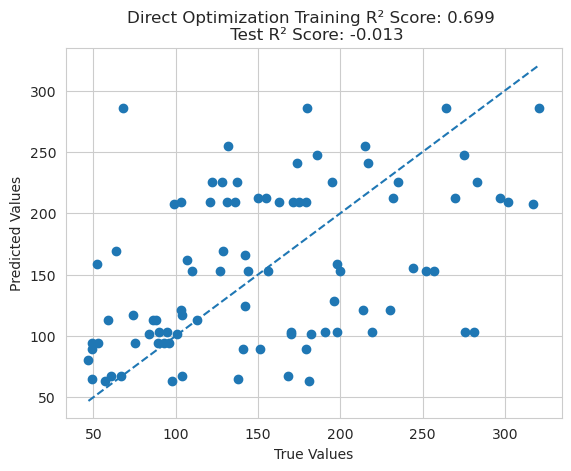

-0.013256758248239464

In [9]:
def evalFeatureEngineeringTrainingError(individuals):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 使用决策树进行回归
    model = DecisionTreeRegressor(min_samples_leaf=10)
    model.fit(new_features, train_y)

    # 返回训练误差
    return r2_score(train_y, model.predict(new_features)),


toolbox.register("evaluate", evalFeatureEngineeringTrainingError)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=stats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)
evaluationOnTest(best_ind, "Direct Optimization")

首先我们来观察进化过程中的关键指标变化：

最初状态（第0代）：
- 平均适应度(avg)：0.304
- 最佳适应度(max)：0.453
- 适应度标准差(std)：0.144
这表明初始种群的表现参差不齐，存在较大差异。

快速进步阶段（第1代）：
- 平均适应度显著提升到0.560
- 最佳适应度跃升至0.666
- 标准差降低到0.099
这是一个重要的突破，说明算法很快就找到了更好的特征组合方案。

稳定优化阶段（第2-10代）：
- 平均适应度在0.59-0.61之间波动
- 最佳适应度在0.67-0.70之间小幅提升
- 标准差进一步降低到约0.065-0.082
这表明种群逐渐收敛到一个相对稳定的解空间。

最终的最佳个体分析：
```python
最佳特征组合：
1. subtract(ARG0, add(ARG1, ARG2))  # 简化为：ARG0 - (ARG1 + ARG2)
2. add(ARG8, ARG2)                  # 简化为：ARG8 + ARG2
3. 复杂特征组合：
   add(
     subtract(
       add(ARG6, ARG6),             # 2*ARG6
       multiply(add(ARG9, ARG0), ARG3)  # (ARG9 + ARG0) * ARG3
     ),
     multiply(ARG6, add(ARG6, ARG0))    # ARG6 * (ARG6 + ARG0)
   )
```

与之前使用交叉验证的结果相比：
1. 适应度提升：
   - 之前的最佳适应度约为0.454
   - 现在的最佳适应度达到0.699
   这表明直接优化训练误差确实能找到更"适合"训练数据的特征。

2. 特征复杂度：
   - 前两个特征保持相对简单
   - 第三个特征变得明显更复杂
   这可能表明算法在试图捕捉更细微的数据模式。

3. 进化过程的稳定性：
   - 标准差总体呈下降趋势
   - 平均适应度稳定提升
   这说明种群在向更好的解空间收敛。

需要注意的关键点：
1. 虽然训练集表现提升明显，但需要警惕过拟合风险。特别是第三个特征的复杂程度可能导致模型过度拟合训练数据。

2. 特征组合的可解释性：
   - 前两个特征保持了良好的可解释性
   - 第三个特征变得难以直观理解，这可能在实际应用中造成困扰

3. 算法收敛特征：
   - 在第8代达到最佳值0.699
   - 之后的代际并未带来进一步提升
   这可能暗示我们已经接近了当前参数设置下的最优解

但是可视化图表示出了过拟合：

首先，让我们看看关键指标：
- 训练集R²分数：0.699（非常好）
- 测试集R²分数：-0.013（极其糟糕）

这两个分数之间的巨大差距告诉我们发生了严重的过拟合。想象一个学生，他完全记住了练习题的答案（训练集表现好），但在考试中遇到稍微不同的题目就完全不会做了（测试集表现差）。

从散点图的分布来看：
1. 预测值的分布非常分散，很多点远离理想预测线（蓝色虚线）
2. 似乎没有明显的预测模式，点的分布看起来几乎是随机的
3. 甚至有些预测与实际值呈负相关的趋势（这就是为什么R²为负）

为什么会这样？原因在于我们的优化策略：
1. 直接优化训练误差而不是使用交叉验证
2. 允许特征变得过于复杂（记得那个很长的第三个特征表达式）
3. 决策树可能过度拟合了这些复杂特征

这个结果很好地说明了为什么在机器学习中，我们不能单纯追求训练集上的高分数，而要更注重模型的泛化能力。

### 传统特征工程方法
最后，我们可以使用传统的特征工程方法，例如神经网络和Kernel方法来构造新特征，然后训练模型，看看它们的性能如何。

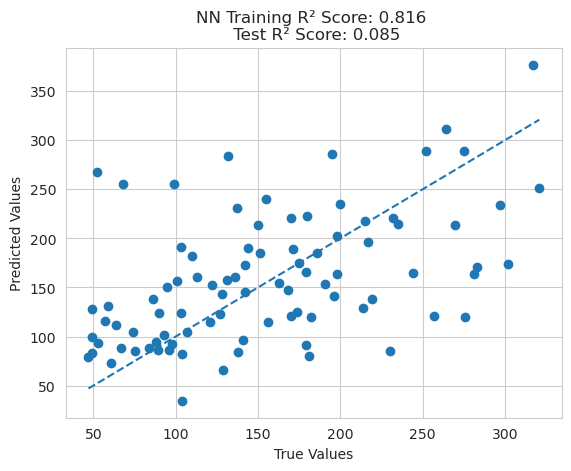

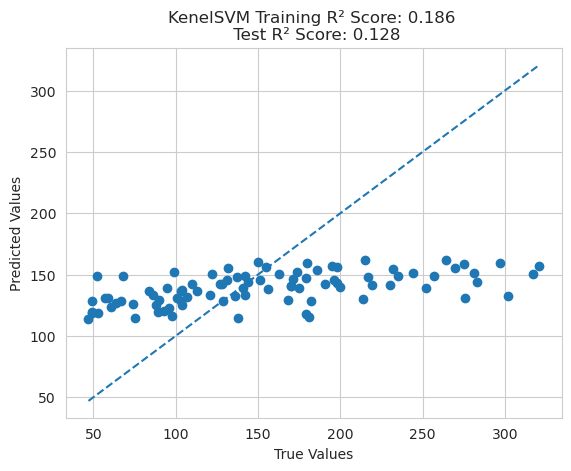

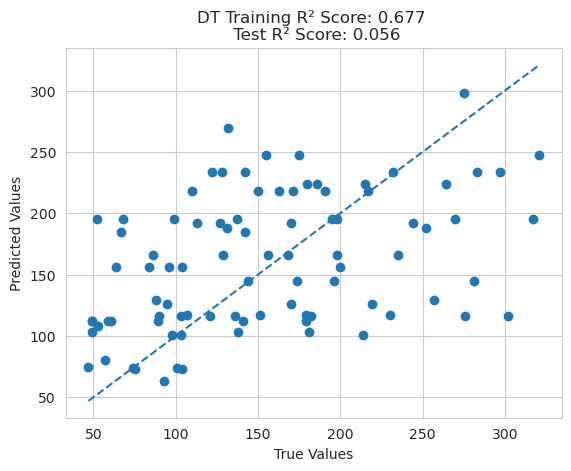

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# 使用神经网络
model = MLPRegressor(learning_rate_init=0.01, max_iter=10000)
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "NN")

# 使用核SVM
model = SVR()
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "KenelSVM")

# 使用决策树
model = DecisionTreeRegressor(min_samples_leaf=10)
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "DT")

从上面的结果可以看出，遗传编程的特征工程方法在测试集上的性能要优于传统的特征工程方法。验证了GP的优势。
另外，特别重要的是，遗传编程特征工程方法优化交叉验证误差，而不是直接优化训练误差，导致了其更好的泛化性能。
如果直接优化训练误差，则会导致过拟合，不能很好地泛化到测试集上。

详细分析这三种传统机器学习方法与我们之前使用的遗传编程方法的表现：

首先，让我们看看每种方法的表现指标：

1. 神经网络(NN)：
- 训练集 R² = 0.816
- 测试集 R² = 0.085
这显示了严重的过拟合问题。神经网络在训练数据上表现极好，但完全无法泛化到新数据。这就像一个学生完美地记住了所有练习题，但在考试中遇到稍微不同的题目就束手无策。

2. 核支持向量机(KernelSVM)：
- 训练集 R² = 0.186
- 测试集 R² = 0.128
这是最稳定的模型，训练集和测试集的表现差距最小。虽然整体性能不高，但至少显示出了一定的泛化能力。从散点图可以看出，预测值的范围比较集中，说明模型较为保守。

3. 决策树(DT)：
- 训练集 R² = 0.677
- 测试集 R² = 0.056
这个结果与神经网络类似，也存在明显的过拟合现象，但程度稍轻。

对比之前的遗传编程方法：

1. 使用交叉验证的GP：
- 训练集 R² ≈ 0.656
- 测试集 R² = 0.179
这个结果实际上是所有方法中最好的，特别是在测试集表现上。

2. 直接优化的GP：
- 训练集 R² = 0.699
- 测试集 R² = -0.013
这个结果展示了过度优化训练误差的危险。

从这些结果我们可以得出几个重要的见解：

1. 过拟合是普遍问题：
所有方法都显示出不同程度的过拟合，这暗示着数据本身可能存在一些固有的挑战，比如噪声较大或特征与目标之间的关系不够明显。

2. 简单未必就是最好：
KernelSVM虽然预测最保守，但其实并没有捕捉到数据中的重要模式。这就像一个总是猜测平均值的学生，虽然不会犯大错，但也学不到真正的知识。

3. 交叉验证的重要性：
使用交叉验证的GP方法获得了最好的泛化性能，这证明了良好的验证策略对于构建可靠模型的重要性。